### Импорт библиотек

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model
import pydot

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Загрузка файлов и первичное знакомство с ними

In [2]:
train_path = 'data/fashion-mnist_train.csv'
test_path = 'data/fashion-mnist_test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
display(train_data.head())
display(test_data.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Создаем словарь, для удобства проверки качества классификации
glossary = {0: 'Футболка', 1: 'Брюки', 2: 'Свитер', 3: 'Платье',
            4: 'Пальто', 5: 'Сандалия', 6: 'Рубашка', 7: 'Кроссовок',
            8: 'Сумка', 9: 'Сапог'}

### Первичная обработка данных

Число записей: 60000
Число найденных дубликатов: 86


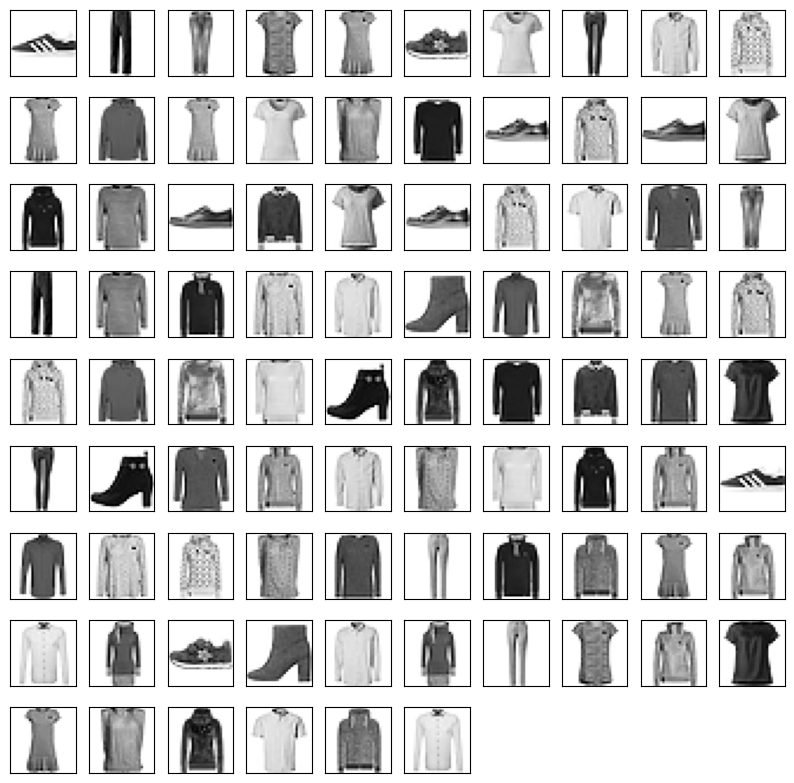

In [19]:
# Проверяем наличие дубликатов в колонках
duplicates = train_data[train_data.duplicated(keep = False)]
# Прреобразуем данные для дальнейшего отображения
duplicates = duplicates.drop(columns='label').values.reshape((duplicates.shape[0], 28, 28))

print(f'Число записей: {train_data.shape[0]}')
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

# Посмотрим на найденные дубликаты
plt.figure(figsize=(10,10))
for i in range(duplicates.shape[0]):
    plt.subplot(duplicates.shape[0]//10+1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(duplicates[i], cmap="Greys")
plt.show()

In [20]:
# Удаление дубликатов
train_data = train_data.drop_duplicates()
print(f'Результирующее число записей: {train_data.shape[0]}')

Результирующее число записей: 59957


In [21]:
# Исследование пропусков
cols_null_percent = train_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(f'Количество колонок с пропусками: {cols_with_null.shape}')

'Количество колонок с пропусками: (0,)'

### Подготока данных к обучению

In [22]:
# Выделяем целевую переменную и удаляем ее из основного датасета
y_train = train_data['label'].values #берём таргет
train_num = train_data.shape[0]
# Сразу преобраовываем данные для дальнейшего обучения
x_train = train_data.drop(columns='label').values.reshape((train_num, 28, 28))

y_test = test_data['label'].values #берём таргет
test_num = test_data.shape[0]
# Сразу преобраовываем данные для дальнейшего обучения
x_test = test_data.drop(columns='label').values.reshape((test_num, 28, 28))

# Проверка корректности
print(f'Размер обучающей выборки: {x_train.shape}')
print(f'Размер тестовой выборки: {x_test.shape}')

Размер обучающей выборки: (59957, 28, 28)
Размер тестовой выборки: (10000, 28, 28)


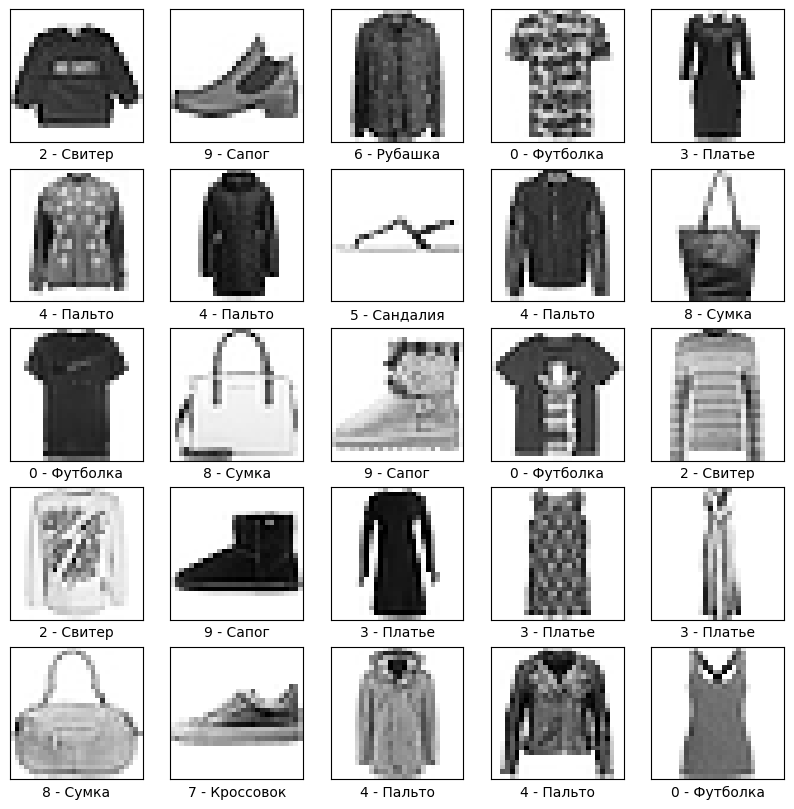

In [23]:
# Посмотрим примеры картинок для классификации
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(str(y_train[i]) + ' - ' + glossary[y_train[i]]) # вывод красивой подписи
plt.show()

In [24]:
# Центрируем и нормируем данные
x_train_float = x_train.astype(float) / 255 - 0.5
x_test_float = x_test.astype(float) / 255 - 0.5
# Проверка корректности
print(x_train_float[1, 1, 10:20])
print(x_test_float[1, 1, 10:20])

[-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]
[-0.40588235  0.42156863  0.32352941  0.44509804  0.37058824  0.17058824
  0.3627451   0.28039216  0.4254902  -0.39411765]


In [25]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_test_oh = keras.utils.to_categorical(y_test, 10)
# Проверка корректности
print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(59957, 10)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]] [2 9 6 0 3]


### Обучение сети

In [36]:
clear_session()

In [37]:
# Создаем модель
model = Sequential()
model.add(Input((28,28,1)))
# Первый сверточный слой 32 нейрона, размер ядра свертки 3х3, шаг 1, 
# добавляем рамку, чтобы сохранить рамер изображения
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same'))
model.add(MaxPool2D())
# Второй сверточный слой, аналогично первому, но 64 нейрона
model.add(Conv2D(64, kernel_size=3, strides=1, padding='same'))
model.add(MaxPool2D())
# Третий сверточный слой, аналогично первому, но 128 нейронов
model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
model.add(MaxPool2D())
# Полученные данные вытягиваем в вектор значений
model.add(Flatten())
# Финальный полносвязный слой с 10 нейронами, соответсвующими 10 классам одежды
model.add(Dense(10, activation='softmax'))

In [38]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [53]:
# Визуализируем модель
#keras.utils.plot_model(model, show_shapes = True) # не работает в VS code
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Обучаем модель
history = model.fit(
    x_train_float[:, :, :, np.newaxis],
    y_train_oh,
    batch_size=64,
    epochs=5,
    validation_data=(x_test_float[:, :, :, np.newaxis], y_test_oh)
)

Epoch 1/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.7742 - loss: 0.6402 - val_accuracy: 0.8903 - val_loss: 0.3176
Epoch 2/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.8906 - loss: 0.3025 - val_accuracy: 0.8978 - val_loss: 0.2845
Epoch 3/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9069 - loss: 0.2567 - val_accuracy: 0.9090 - val_loss: 0.2583
Epoch 4/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9223 - loss: 0.2208 - val_accuracy: 0.9155 - val_loss: 0.2435
Epoch 5/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.9339 - loss: 0.1894 - val_accuracy: 0.9159 - val_loss: 0.2449


### Получение предсказания и оценка точности модели

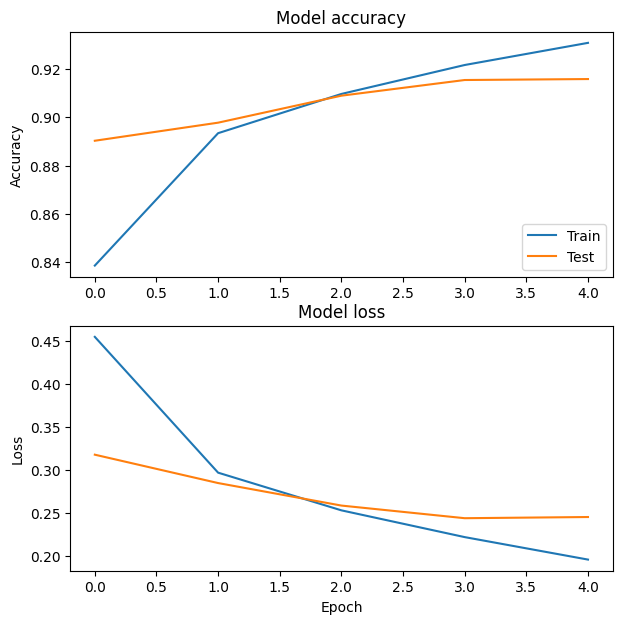

In [55]:
# Построим график точности в зависимости от эпохи
plt.style.use(['default'])
fig, ax = plt.subplots(figsize=(7,7), nrows=2, ncols=1)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Test'], loc='lower right')

# Построим график потерь в зависимости от эпохи
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
plt.show()

In [56]:
# Сделаем предсказание на тестовых данных
predicts=model.predict(x_test_float)
classes_x=np.argmax(predicts,axis=1)

# Посмотрим на точность предсказания на тестовых данных
print('Test Accuracy: ', accuracy_score(y_test, classes_x))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Test Accuracy:  0.9159


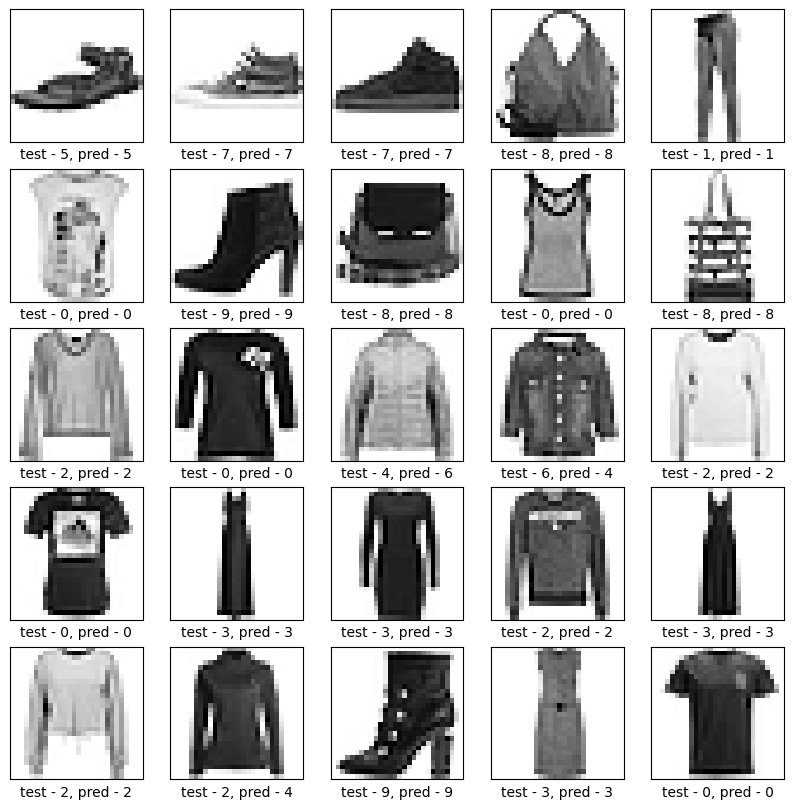

In [57]:
# Посмотрим на качество классификации
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i+30], cmap="Greys")
    x_lab = 'test - ' + str(y_test[i+30]) + ', pred - ' + str(classes_x[i+30])
    plt.xlabel(x_lab)
plt.show()

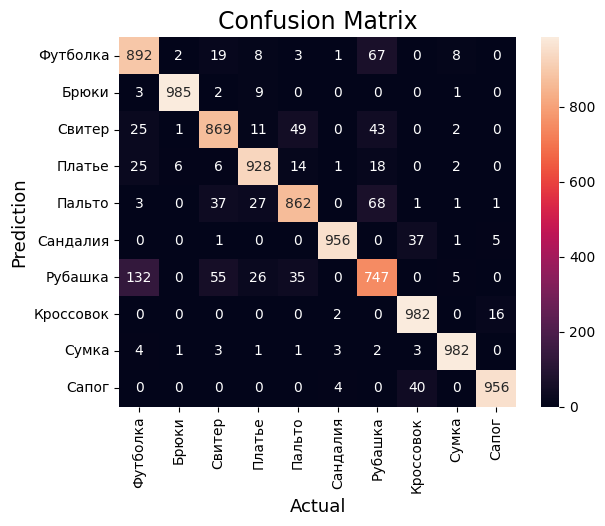

In [58]:
# Построим матрицу ошибок для тестового набора
cloth_name = ['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто',
              'Сандалия', 'Рубашка', 'Кроссовок', 'Сумка', 'Сапог']
con_mat = confusion_matrix(y_test, classes_x)
sns.heatmap(con_mat,
            annot=True,
            fmt='g',
            xticklabels=cloth_name,
            yticklabels=cloth_name)
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

In [59]:
# Сохраним полученное предсказание
id = np.arange(y_test.shape[0])
result = pd.DataFrame({
    'Id': id,
    'Category': classes_x
})
result_path = 'data/result.csv'
result.to_csv(result_path, index=False)

В итоге была построена нейронная сеть, которая классифицирует изображения из данных датасетов с качеством ~92%.